In [1]:
import numpy as np
from IPython.display import clear_output
from numpy import linalg as LA
%matplotlib inline
import matplotlib.pyplot as pl
from mpl_toolkits.mplot3d.axes3d import Axes3D

from PIL import Image
from scipy.optimize import minimize
import f_class
from GP import GP
from GP_grad import GP_grad
from GD_machine import GD_machine
import time
import imageio
from torch.quasirandom import SobolEngine
import sobol_seq
from utils import *
import numdifftools as nd

#### Noiseless & Noisy

In [2]:
Noise = False # Specify if noisy or not
Noise_level = 0.00 # if noisy, what is the noise sd
'''If use the scaled X and y, rememeber to scale the noise as well'''

'If use the scaled X and y, rememeber to scale the noise as well'

#### High-dimensional function $f$

In [3]:
objective = f_class.Hartmann_6(Noise, Noise_level)

# objective = f_class.Alpine(Noise, Noise_level) 
objective = f_class.Ackley(Noise, Noise_level)
objective = f_class.Ackley_2(Noise, Noise_level)
# objective = f_class.Shubert_2(Noise, Noise_level)
# objective = f_class.Michalewicz(Noise, Noise_level)
# objective = f_class.Schwefel(Noise, Noise_level, dim=20)
# objective = f_class.Rosenbrock(Noise, Noise_level)
# objective = f_class.Griewank(Noise, Noise_level)
# objective = f_class.Levy(Noise, Noise_level, dim=20) 
# objective = f_class.Rastrigin(Noise, Noise_level, dim=10)

f = objective.func
clean_f = lambda x: f_class.Hartmann_6().func(x)
# clean_f = lambda x: f_class.Alpine().func(x)
clean_f = lambda x: f_class.Ackley().func(x)
clean_f = lambda x: f_class.Ackley_2().func(x)
# clean_f = lambda x: f_class.Shubert_2().func(x)
# clean_f = lambda x: f_class.Michalewicz().func(x)
# clean_f = lambda x: f_class.Schwefel(dim=20).func(x)
# clean_f = lambda x: f_class.Rosenbrock().func(x)
# clean_f = lambda x: f_class.Griewank().func(x)
# clean_f = lambda x: f_class.Levy(dim=20).func(x)
# clean_f = lambda x: f_class.Rastrigin(dim=10).func(x)
B = np.array([item[1] for item in sorted(objective.bounds.items(), key=lambda x: x[0])], dtype=np.float64)
print(B) 
lb = B[:, 0]; ub = B[:, 1]


dim = objective.input_dim
print('dim: ', dim)
# print(f( np.array([dim*[1], dim*[1]])))

[[-4.  5.]
 [-4.  5.]]
dim:  2


#### Finding Optimized Hyperparameter $\sigma, \ell \rightarrow$ Online Update of Hyperparameter

In [4]:
# set seed
seed = 0
def random_draw(n_random_draws=3):
    """ samples some points"""
    # should draw randomly
    return np.random.uniform(lb, ub, size=(n_random_draws, dim))


def optimize_hyper(lb, ub, sample_size=2000):
#     np.random.seed(seed)
    X = np.asarray(np.random.uniform(lb, ub, size=(sample_size, dim)))
    gp.set_data(X, f(X))
    ls, var = gp.optimize()
    gp.clear()
    return (ls, var)

In [5]:
# # find optimized hyper, if online, skip this part
# gp = GP_grad(B, Noise, Noise_level)
# (ls, var) = optimize_hyper(lb, ub, sample_size=2000)
# del gp
# (ls, var)

### Grid

In [6]:
# n_Grid = dim
# G = np.zeros((dim, n_Grid))
# for i in range(dim):
#     G[i] = np.linspace(lb[i], ub[i], n_Grid)

# Grid = np.vstack( [axis.flatten() for axis in np.meshgrid(*(G[i] for i in range(G.shape[0])))] ).T
# Grid.shape

### Grid Approx Gradient

In [7]:
# # approximate the gradient
# from scipy import optimize

# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape

In [8]:
# # 3d plot of the gradient
# # approximate the gradient
# from scipy import optimize

# # optimize.approx_fprime(x, clean_Ackley_1d, eps)
# eps = np.sqrt(np.finfo(float).eps)
# approx_grad = np.array([optimize.approx_fprime(x, lambda x: clean_f(x).item(), eps) for x in Grid])
# approx_grad.shape
# g1 = approx_grad[:, 0]
# g2 = approx_grad[:, 1]
# g1, g2

# BO

In [9]:
MAX = 100 # function observations

## Gradient-based Method

##### 1. Setup

In [10]:
# initial data
setup = 5
X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))

# sample from a small 2d box
# Xc = np.asarray(np.random.uniform(lb, ub, size=(1, dim)))
# X = close_draw(Xc, n_random_draws=setup)

# X = np.vstack([X, np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))])

In [11]:
gp = GP_grad(B, Noise, Noise_level, compress=True)
# gp.set_hyper(ls, var)  # if online, skip

gp.set_data(X, f(X))
ls, var = gp.optimize()
gp.set_hyper(ls, var)
gp.fit()

# w: starting point of GD
# w = X[0].reshape(1, dim)
history = [(w, f(w)) for w in X]

In [12]:
w = X[0].reshape(1, dim)
gp.posterior(w), gp._normal(f(w))

((array([[-0.04459636]]), array([[1.00000001e-08]])), array([[-0.04459636]]))

##### 2. Warm up

In [13]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
# warmup = 30
# history_warmup = []
# for i in range(1, warmup+1):
#     b = np.log(i)
#     w, fw = gp.ucb_minimize(b)
#     X = np.vstack([X, w])
    
#     print(i, end = ', ')
#     print('w: ', w, end = ', ')
#     print('f(w): ', f(w).item(), end = ', ')
#     print()
    
#     gp.add_data(w.reshape(1, dim), f(w))
    
#     if i % 5 == 0:
#         ls, var = gp.optimize()
#         print('  # Optimal (ls, var) = ', (ls, var))
#     gp.fit()
#     history.append( (w, f(w)) )
    
# X_fix = X

In [14]:
# gp.posterior_full_grad('full', dim*[w]), gp.posterior_grad(w)
warmup = 0
for i in range(1, warmup+1):
    w = gp.thompson_sample(n_mesh=gp.dim*100)
    gp.add_data(w.reshape(1, dim), f(w))
    if i % 5 == 0:
        ls, var = gp.optimize()
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()    
                
    X = np.vstack([X, w])
    print(i, end = ', ')
    print('w: ', w, end = ', ')
    print('f(w): ', f(w).item(), end = ', ')
    print()
    history.append( (w, f(w)) )
    
X_fix = X

In [15]:
gp.get_normal()

(7.7430929226041725, 2.2446619719315963)

##### 3. Optimize via GD

In [16]:
GD = GD_machine(gp, w, f)

from scipy import optimize
eps = np.sqrt(np.finfo(float).eps)
gp.grad(w), gp.grad_sample(w), optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)

(array([[ 2.36186072e-23, -1.10570214e-22]]),
 array([[-7.51524118,  3.55500945]]),
 array([-2.89720905, -3.00313556]))

In [17]:
gp.optimize()
gp.fit()
np.set_printoptions(precision=4)
cost = setup + warmup
y_best = np.min(f(gp.X))

# create a candidate list of GD points from all queried points so far
GD_House = [GD_machine(gp, w, f) for w in gp.X]

In [18]:
import time
import random
ts_count = 0

GD_FAIL = 0
MAX_GD_FAIL = 5

M = 1

while MAX - cost >= 0:
    # print out y_best, cost
    y_best = np.min(f(gp.X))
    arg_y_best = np.argmin(f(gp.X))
    print(cost, end = '. ')
    
    # identify the local GD
    GD_cand = sorted(filter(lambda x: x.STOP >= x.FAIL, GD_House), key=lambda x: x.min)[:M]
    GD_cand_No = [GD_House.index(cand) for cand in GD_cand]
            
    All_GD_path = []
    
    # pick GD via lowest UCB
    min_ei = np.inf
    best_GD_No = np.inf
    
    for i in GD_cand_No:
        w, GD_path = GD_House[i].update(commit=False)
        All_GD_path.append(GD_path)

        eta = 0 # np.abs(1e-3 * GD_House[i].min)
        path_ei = np.mean([gp.EI(inner_w, GD_House[i].min - eta) for inner_w in GD_path])
        
        # best
        if path_ei < min_ei:
            min_ei = path_ei
            best_W = w
            best_GD_No = i

    if GD_FAIL < MAX_GD_FAIL and len(GD_cand) >= M:
        assert len(GD_cand) == 1 # just GD-1
        best_GD = GD_House[best_GD_No]
        print('GD Query > ', GD_cand_No)
        print('    Pick GD No, PrevLoops, PrevMin = ', (best_GD_No, len(best_GD.history_full_w), best_GD.min.item()))
        w = best_W
              
        # update the picked GD 
        print('    Forward Steps = ', len(All_GD_path[GD_cand_No.index(best_GD_No)]) )
        best_GD.commit(w, All_GD_path[GD_cand_No.index(best_GD_No)])
        
        if f(w) < y_best:
            GD_FAIL = 0
        else:
            GD_FAIL += 1  
    else:
        # Option 2: thompson_sample
        w = gp.thompson_sample(n_mesh=4000)
        ts_count += 1
        print('Thompson Query > ', ts_count)
        GD_House.append(GD_machine(gp, w, f))
        print('add in the new thompson point', GD_House.index(GD_House[-1]))
        GD_FAIL = 0

   
    print('    Normal f(w): %.4f ' % gp._normal(f(w).item()) )
    print('    Predict f(w): (%.4f, %.4f) ' % gp.posterior(w))
    gp.add_data(w.reshape(1, -1), f(w))
    cost += 1
        
    # online hyper udpate + fitting GP with new query w
    ls, var = gp.optimize()
    gp.set_hyper(ls, var)
    print('  # Optimal (ls, var) = (%.4f, %.4f)' % (ls, var))
    gp.fit()
    
    history.append( (w, f(w)) )
    m, v = gp.posterior_full_grad('full', dim*[w])
    v = np.sqrt(np.diag(v))
    print('    w: ', np.squeeze(w), end = ', ')
    print('    f(w): %.4f ' % f(w).item())
    print('    d(w): ', np.squeeze(m))
    print('    s.d: ', np.squeeze(v))
    print('    g(w):', gp._normal_grad(optimize.approx_fprime(np.squeeze(w), lambda x: clean_f(x).item(), eps)))
    print('    y best, No: ', y_best, [arg_y_best])
    print()
        
print('Max Cost reached = ', cost)

5. 0.002279907627776265
0.01939558049160987
GD Query >  [1]
    Pick GD No, PrevLoops, PrevMin =  (1, 1, 5.109425833431054)
    Forward Steps =  1
    Normal f(w): -1.1784 
    Predict f(w): (-1.1733, 0.0001) 
  # Optimal (ls, var) = (0.4562, 1.0147)
    w:  [-0.2994  1.2329],     f(w): 5.0979 
    d(w):  [-2.0216  0.8997]
    s.d:  [0.8994 2.0177]
    g(w): [-1.4365  2.254 ]
    y best, No:  5.109425833431054 [1]

6. 0.27628169690240173
0.04771628332482651
0.14378925215806812
0.0014621866221539678
0.006462472746428103
GD Query >  [1]
    Pick GD No, PrevLoops, PrevMin =  (1, 2, 5.097917851350424)
    Forward Steps =  4
    Normal f(w): -1.7574 
    Predict f(w): (-1.3155, 0.0596) 
  # Optimal (ls, var) = (0.5464, 1.2545)
    w:  [-0.0401  1.119 ],     f(w): 3.3060 
    d(w):  [-2.4211  1.0375]
    s.d:  [0.8423 1.8821]
    g(w): [-0.7595  2.9342]
    y best, No:  5.097917851350424 [5]

7. 0.33706193978451193
0.14279793548472225
0.1376217570767738
0.008095592996291815
GD Query >  [1]
 

0.004487341119721532
0.010385268808342516
0.01454278069678694
GD Query >  [4]
    Pick GD No, PrevLoops, PrevMin =  (4, 21, 2.5800138527312417)
    Forward Steps =  3
    Normal f(w): -0.8782 
    Predict f(w): (-0.8782, 0.0000) 
  # Optimal (ls, var) = (0.4030, 1.1367)
    w:  [0.0012 0.9505],     f(w): 2.5800 
    d(w):  [0.0008 0.0005]
    s.d:  [0.0298 0.0215]
    g(w): [ 0.0212 -0.0256]
    y best, No:  2.5799854742968873 [15]

26. 0.002108105667401105
0.011125231762230396
0.0010056042838841677
0.004480057326797396
0.03458036930393428
GD Query >  [4]
    Pick GD No, PrevLoops, PrevMin =  (4, 24, 2.5800138527312417)
    Forward Steps =  4
    Normal f(w): -0.8486 
    Predict f(w): (-0.8486, 0.0000) 
  # Optimal (ls, var) = (0.4311, 1.8040)
    w:  [0.0012 0.9506],     f(w): 2.5800 
    d(w):  [0.0017 0.0029]
    s.d:  [0.0299 0.0219]
    g(w): [ 0.0217 -0.0238]
    y best, No:  2.5799854742968873 [15]

27. 0.013634427179209888
0.026954506330285222
0.013563584120757878
Thompson Que

45. 4.597947395515442
1.512244915021956
2.3700545087546114
0.4605065223366022
0.09525401232596488
1.8691089933633804
0.19972091967761516
0.061956282891333106
0.04726426907302812
0.01962900551939383
GD Query >  [5]
    Pick GD No, PrevLoops, PrevMin =  (5, 3, 8.243127019016216)
    Forward Steps =  9
    Normal f(w): -0.8393 
    Predict f(w): (-0.8392, 0.0000) 
  # Optimal (ls, var) = (0.4535, 3.4308)
    w:  [3.7230e-04 9.5155e-01],     f(w): 2.5799 
    d(w):  [0.0014 0.0082]
    s.d:  [0.0242 0.0182]
    g(w): [ 0.0062 -0.0088]
    y best, No:  2.5799430419343925 [28]

46. 0.01146948108235374
0.12231808905266225
0.010708815057668835
GD Query >  [5]
    Pick GD No, PrevLoops, PrevMin =  (5, 12, 2.5799402713727706)
    Forward Steps =  2
    Normal f(w): -0.8238 
    Predict f(w): (-0.8238, 0.0000) 
  # Optimal (ls, var) = (0.4514, 11.5604)
    w:  [4.7986e-05 9.5098e-01],     f(w): 2.5800 
    d(w):  [ 0.0002 -0.0069]
    s.d:  [0.0251 0.0207]
    g(w): [ 0.0008 -0.0171]
    y best, 

2.6486194727599623
0.06863171566100791
0.06256987329525873
0.02953027846440673
0.0043054893691092735
0.0034006143026985227
0.026607817903440446
0.0627870208479464
0.025740384382475168
GD Query >  [9]
    Pick GD No, PrevLoops, PrevMin =  (9, 1, 8.62493277152565)
    Forward Steps =  9
    Normal f(w): -0.7536 
    Predict f(w): (-0.7536, 0.0000) 
  # Optimal (ls, var) = (0.4369, 2.2468)
    w:  [1.0437e-04 9.5102e-01],     f(w): 2.5800 
    d(w):  [-0.001  -0.0022]
    s.d:  [0.0216 0.0154]
    g(w): [ 0.0017 -0.0166]
    y best, No:  2.5799306038064675 [50]

65. 0.00681229597022757
0.03190773697299883
GD Query >  [9]
    Pick GD No, PrevLoops, PrevMin =  (9, 10, 2.5799591384928964)
    Forward Steps =  1
    Normal f(w): -0.7446 
    Predict f(w): (-0.7446, 0.0000) 
  # Optimal (ls, var) = (0.4328, 2.1708)
    w:  [6.1661e-05 9.5108e-01],     f(w): 2.5800 
    d(w):  [-0.0016 -0.0018]
    s.d:  [0.0216 0.0154]
    g(w): [ 0.001  -0.0157]
    y best, No:  2.5799306038064675 [50]

66. 0

0.016660637784842402
GD Query >  [12]
    Pick GD No, PrevLoops, PrevMin =  (12, 13, 0.05441725254156227)
    Forward Steps =  5
    Normal f(w): -1.3362 
    Predict f(w): (-1.3262, 0.0000) 
  # Optimal (ls, var) = (0.2012, 2.7375)
    w:  [0.0005 0.0022],     f(w): 0.0066 
    d(w):  [0.0133 1.0485]
    s.d:  [0.1962 0.3727]
    g(w): [0.2037 0.8387]
    y best, No:  0.05441725254156227 [81]

84. 0.037104014961421496
0.04152060859818012
GD Query >  [12]
    Pick GD No, PrevLoops, PrevMin =  (12, 18, 0.006592550301789846)
    Forward Steps =  1
    Normal f(w): -1.2779 
    Predict f(w): (-1.3418, 0.0001) 
  # Optimal (ls, var) = (0.1702, 5.5967)
    w:  [ 0.0041 -0.0347],     f(w): 0.1311 
    d(w):  [ 0.5762 -0.7048]
    s.d:  [0.514  0.4528]
    g(w): [ 0.158  -1.3474]
    y best, No:  0.006592550301789846 [83]

85. 0.022104547969065608
0.3133408138830215
0.010013284078799188
GD Query >  [12]
    Pick GD No, PrevLoops, PrevMin =  (12, 19, 0.006592550301789846)
    Forward Steps =  

<ipython-input-20-84ae80d9bb6a>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history)[:, 1]), "^-", lw=0.5)
<ipython-input-20-84ae80d9bb6a>:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)


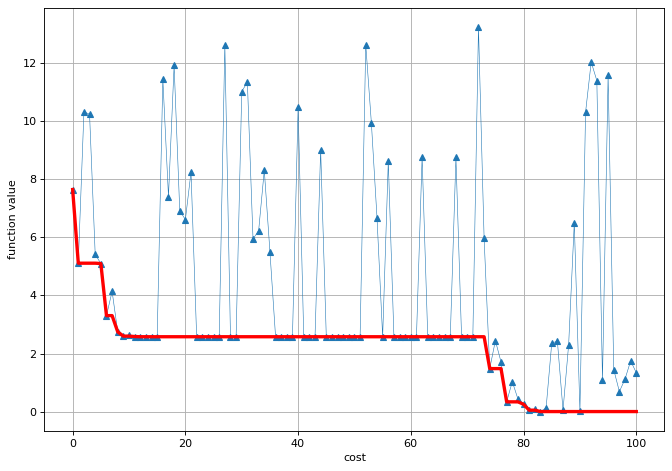

In [20]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history)[:, 1]), "^-", lw=0.5)
pl.xlabel("cost")
pl.plot(np.minimum.accumulate(np.array(history)[:, 1]), 'r', lw=3)
pl.ylabel("function value")
pl.grid(True)
# pl.ylim([0, 5]) 

## Minima of GD

In [21]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.0005, 0.0022]), 0.006592550301789846, 83)

In [22]:
gp.get_normal()

(4.400287744436133, 3.599994522605851)

In [23]:
sorted([(GDBO.min.item(), len(GDBO.history_w)) for GDBO in GD_House])

[(0.006592550301789846, 16),
 (0.692584518902319, 12),
 (2.5799306038064675, 9),
 (2.5799430419343925, 13),
 (2.5799437731541457, 8),
 (2.57994437577575, 13),
 (2.579956765407506, 11),
 (2.5799854742968873, 12),
 (6.504896921807955, 1),
 (8.772215521597275, 1),
 (10.232397066621326, 1),
 (10.316835669675621, 1),
 (10.480077005779423, 1),
 (11.57193118852496, 1),
 (12.62550890037676, 1)]

In [24]:
# # only for backtracking
# pl.figure(figsize=(10, 6), dpi=80)
# # pl.plot(history_lr, "-^")
# pl.title("learning rate as the algorithm runs")
# pl.xlabel("n_iter")
# pl.ylabel("learning rate")
# pl.yscale("log")
# pl.grid(True)

### *Thompson Sampling, UCB*

In [25]:
### Thompson Sampling
import os
gp.clear()
# gp.set_hyper(ls, var) # if online update hyper, skip

# init cost
# X = np.asarray(np.random.uniform(lb, ub, size=(setup, dim)))
X = X_fix

gp.set_data(X, f(X))
gp.optimize()
gp.fit()

history_ucb = []
for a in X_fix:
    history_ucb.append( (a, f(a)) )

In [26]:
cost = setup + warmup

while cost < MAX:
    # 1. Thompson Sampling
    w = gp.thompson_sample(n_mesh=4000)
    # 2. GP_UCB
#     b = np.log(cost**gp.dim)
#     w, fw = gp.ucb_minimize(b)
#     w, fw = gp.EI_minimize(y_best=np.min(f(gp.X)))
    if is_new(w, gp.X) == False:
        print('visit before, ignore ', w)
        continue
    

#     fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = pl.subplots(3, 2, figsize=(24, 21))

#     # plot function (ax1, ax2)
#     im = ax2.pcolormesh(X1, X2, s.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax2)

#     im1 = ax1.contour(X1, X2, functions.Ackley_2().func(Grid).reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax1.contour(X1, X2, mu.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax1)
#     fig.colorbar(im2, ax=ax1)

#     ax1.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax1.plot(w[0], w[1], 'ro')
#     ax1.title.set_text("Noisy Ackley")
#     ax2.title.set_text("Standard Deviation")
    
    
#     # plot derivative in (ax3, ax4), (ax5, ax6)
#     im = ax4.pcolormesh(X1, X2, s_grad_1.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im, ax=ax4)
#     im1 = ax3.contour(X1, X2, g1.reshape(X1.shape), cmap="PuBuGn")
#     im2 = ax3.contour(X1, X2, mu_grad_1.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im1, ax=ax3)
#     fig.colorbar(im2, ax=ax3)

#     ax3.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax3.title.set_text("Mean of Posterior Partial x")
#     ax4.title.set_text("Std of Posterior Partial x")

    
#     im3 = ax6.pcolormesh(X1, X2, s_grad_2.reshape(X1.shape), cmap="jet", shading='auto')
#     fig.colorbar(im3, ax=ax6)
#     im4 = ax5.contour(X1, X2, g2.reshape(X1.shape), cmap="PuBuGn")
#     im5 = ax5.contour(X1, X2, mu_grad_2.reshape(X1.shape), cmap="YlOrRd")

#     fig.colorbar(im4, ax=ax5)
#     fig.colorbar(im5, ax=ax5)

#     ax5.plot(gp.X[:, 0], gp.X[:, 1], "ok", markersize=5, alpha=0.8)
#     ax5.title.set_text("Mean of Posterior Partial y")
#     ax6.title.set_text("Std of Posterior Partial y")

#     filename = 'Ackley_' + str(i) + '_noise_TS' +'.png'
#     pl.savefig('2D_Plots/Ackley/' + filename)
#     pl.show()  
    print(cost, end = '. ')
    print('w: ', w)
    print('  f(w): ', f(w).item())
    print('  y_best: ', np.min(f(gp.X)))
    print()
    
    history_ucb.append( (w, f(w)) )
    gp.add_data(w.reshape(1, dim), f(w))
    
    if cost % 3 == 0:
        ls, var = gp.optimize()
        gp.set_hyper(ls, var)
        print('  # Optimal (ls, var) = ', (ls, var))
    gp.fit()
    cost += 1

5. w:  [-3.9404 -3.9671]
  f(w):  11.050272540930813
  y_best:  5.109425833431054

6. w:  [-2.9292  4.7057]
  f(w):  12.216723413749381
  y_best:  5.109425833431054

  # Optimal (ls, var) =  (0.3427889952721983, 0.999999803860633)
7. w:  [-0.7702 -3.0611]
  f(w):  8.226008189727956
  y_best:  5.109425833431054

8. w:  [ 4.9373 -2.2572]
  f(w):  11.885692669215047
  y_best:  5.109425833431054

9. w:  [4.522  1.3621]
  f(w):  12.021522847511973
  y_best:  5.109425833431054

  # Optimal (ls, var) =  (1.0, 0.8806688020468775)
10. w:  [-0.7378  0.4707]
  f(w):  4.457914051765517
  y_best:  5.109425833431054

11. w:  [ 0.5227 -1.153 ]
  f(w):  5.184984147346672
  y_best:  4.457914051765517

12. w:  [-0.6206  2.8278]
  f(w):  8.55815491970895
  y_best:  4.457914051765517

  # Optimal (ls, var) =  (1.0, 0.737160355255957)
13. w:  [1.1074 2.9465]
  f(w):  7.534907133024674
  y_best:  4.457914051765517

14. w:  [-1.8939  1.0578]
  f(w):  5.638071872277845
  y_best:  4.457914051765517

15. w:  [0

84. w:  [-0.4868  0.5236]
  f(w):  4.2711205074104726
  y_best:  0.18454656089230115

  # Optimal (ls, var) =  (0.22751083047001103, 0.6557291817949885)
85. w:  [3.5567 2.8561]
  f(w):  11.373422415192882
  y_best:  0.18454656089230115

86. w:  [1.8496 3.9024]
  f(w):  9.842020112066077
  y_best:  0.18454656089230115

87. w:  [-2.4253  3.4632]
  f(w):  11.325759606857478
  y_best:  0.18454656089230115

  # Optimal (ls, var) =  (0.22772394309476396, 0.6502024473717641)
88. w:  [3.7336 2.3561]
  f(w):  11.30886551147448
  y_best:  0.18454656089230115

89. w:  [-0.556  0.176]
  f(w):  3.518958985340728
  y_best:  0.18454656089230115

90. w:  [1.4705 4.7806]
  f(w):  12.186137375847716
  y_best:  0.18454656089230115

  # Optimal (ls, var) =  (0.22987189857217205, 0.6483379399175245)
91. w:  [ 4.6317 -0.4061]
  f(w):  11.885154538116982
  y_best:  0.18454656089230115

92. w:  [ 2.4656 -0.2905]
  f(w):  8.098827427439714
  y_best:  0.18454656089230115

93. w:  [-2.0431 -0.9508]
  f(w):  5.56

<ipython-input-27-3916f7118cdf>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
<ipython-input-27-3916f7118cdf>:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)


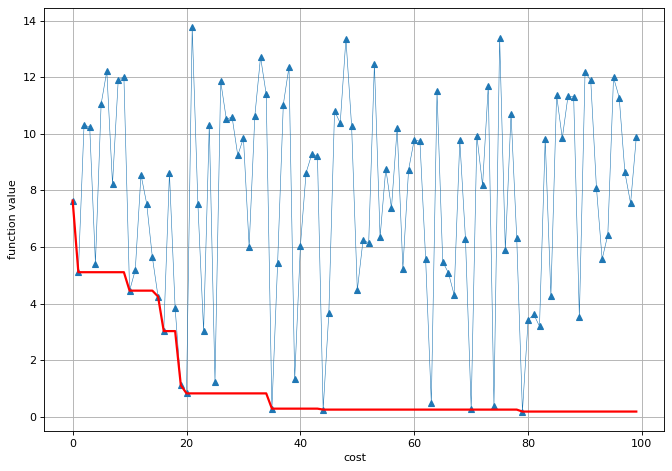

In [27]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.squeeze(np.array(history_ucb)[:, 1]), "-^", lw=0.5)
pl.plot(np.minimum.accumulate(np.array(history_ucb)[:, 1]), 'r', lw=2)
pl.xlabel("cost")
pl.ylabel("function value")
pl.grid(True)

## Global Minima 

In [28]:
gp.X[np.argmin(gp.y)], np.min(gp.y), np.argmin(gp.y)

(array([0.0444, 0.0113]), 0.18454656089230115, 79)

In [29]:
gp.get_hyper()

{'var': 0.6441941590747666, 'lengthscale': 0.23000124487094983}

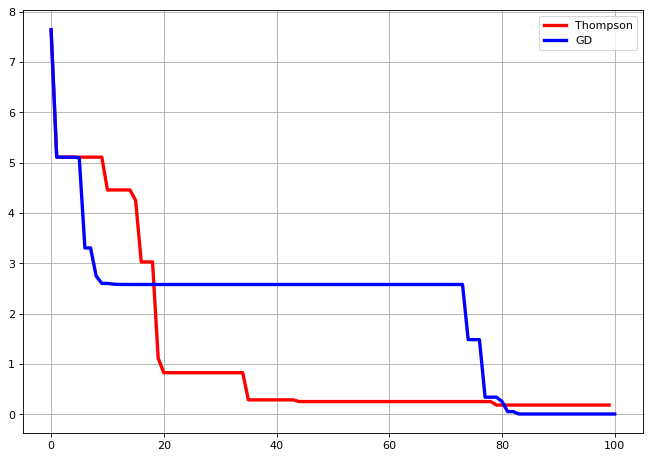

In [30]:
pl.figure(figsize=(10, 7), dpi=80)
pl.plot(np.minimum.accumulate([t[1].item() for t in history_ucb]), 'r', lw=3, label='Thompson')
pl.plot(np.minimum.accumulate([t[1].item() for t in history]), 'b', lw=3, label='GD')
# pl.title("6D Hartmann function on [0, 1]")
pl.legend()
pl.grid(True)
# pl.ylim([0, 100])

In [31]:
import pickle
file_name = "./pkl/GD_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()

In [32]:
file_name = "./pkl/thompson_Ackley5.pkl" 

open_file = open(file_name, "wb")
pickle.dump(np.minimum.accumulate([t[1] for t in history_ucb]), open_file)
open_file.close()

open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()